In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matchms.importing import load_from_mgf
import matchms.filtering as ms_filters
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from matchms.similarity import ModifiedCosine
from spec2vec import Spec2Vec
import gensim
import os
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import SimilarityMaps

In [2]:
#Import the libraries of spectra
pharma_file_mgf= "GNPS-NIH-SMALLMOLECULEPHARMACOLOGICALLYACTIVE.mgf"
natural_file_mgf= "GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf"
spectrumsPharma = list(load_from_mgf(pharma_file_mgf))
spectrumsNatural = list(load_from_mgf(natural_file_mgf))

In [3]:
len(spectrumsPharma) #Visualization of libraries length

1460

In [4]:
len(spectrumsNatural)

1267

In [5]:
 spectrumsPharma = spectrumsPharma[:1266]
 spectrumsNatural = spectrumsNatural[:1266]

# General Filter

In [6]:
#Applying the general filter for intensity peaks and m/z values
def metadata_processing(spectrum): 
    spectrum = ms_filters.default_filters(spectrum) 
    spectrum = ms_filters.add_precursor_mz(spectrum) 
    return spectrum 


def peak_processing(spectrum): 
    spectrum = ms_filters.default_filters(spectrum) 
    spectrum = ms_filters.normalize_intensities(spectrum) 
    spectrum = ms_filters.select_by_intensity(spectrum, intensity_from=0.01) 
    spectrum = ms_filters.select_by_mz(spectrum, mz_from=10, mz_to=1000) 
    return spectrum

In [7]:
#The two lists before the filter
numbers_of_peaks_pharma = [len(s.peaks.mz) for s in spectrumsPharma]
numbers_of_peaks_natural = [len(s.peaks.mz) for s in spectrumsNatural]

In [8]:
#The 1 list after the filter
spectrums_pharma_processed = [metadata_processing(s) for s in spectrumsPharma]
spectrums_pharma_processed = [peak_processing(s) for s in spectrums_pharma_processed]

In [9]:
#The 2 list after the filter
spectrums_natural_processed = [metadata_processing(s) for s in spectrumsNatural]
spectrums_natural_processed = [peak_processing(s) for s in spectrums_natural_processed]

In [10]:
#The two lists after the filter
numbers_of_peaks_pharma_processed = [len(s.peaks.mz) for s in spectrums_pharma_processed]
numbers_of_peaks_natural_processed = [len(s.peaks.mz) for s in spectrums_natural_processed]

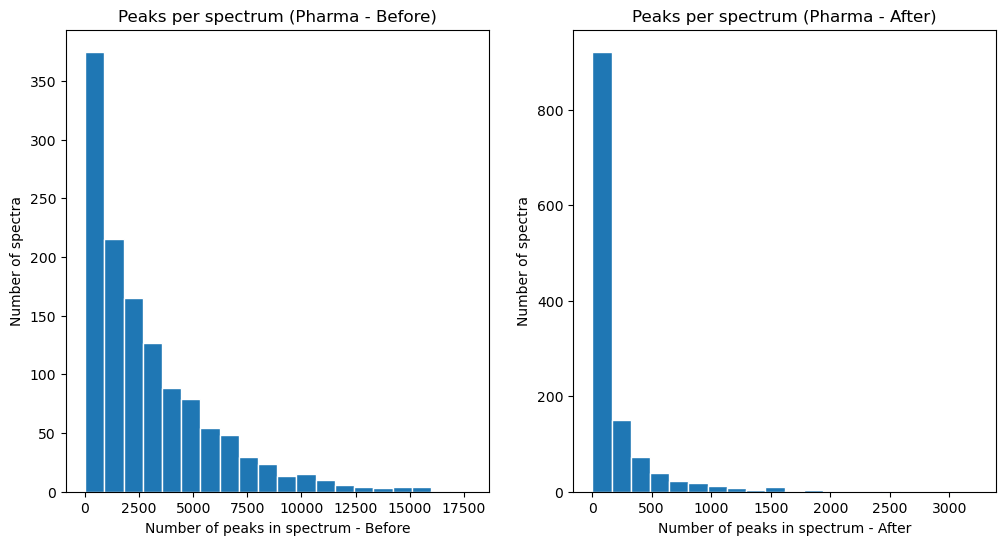

In [17]:
#For plot the before-after the general filter
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi = 100)
ax[0].hist(numbers_of_peaks_pharma, 20, edgecolor="white")
ax[0].set_title("Peaks per spectrum (Pharma - Before)")
ax[1].hist(numbers_of_peaks_pharma_processed, 20, edgecolor="white")
ax[1].set_title("Peaks per spectrum (Pharma - After)")
ax[0].set_xlabel("Number of peaks in spectrum - Before")
ax[1].set_xlabel("Number of peaks in spectrum - After")
ax[0].set_ylabel("Number of spectra")
ax[1].set_ylabel("Number of spectra")
plt.show()

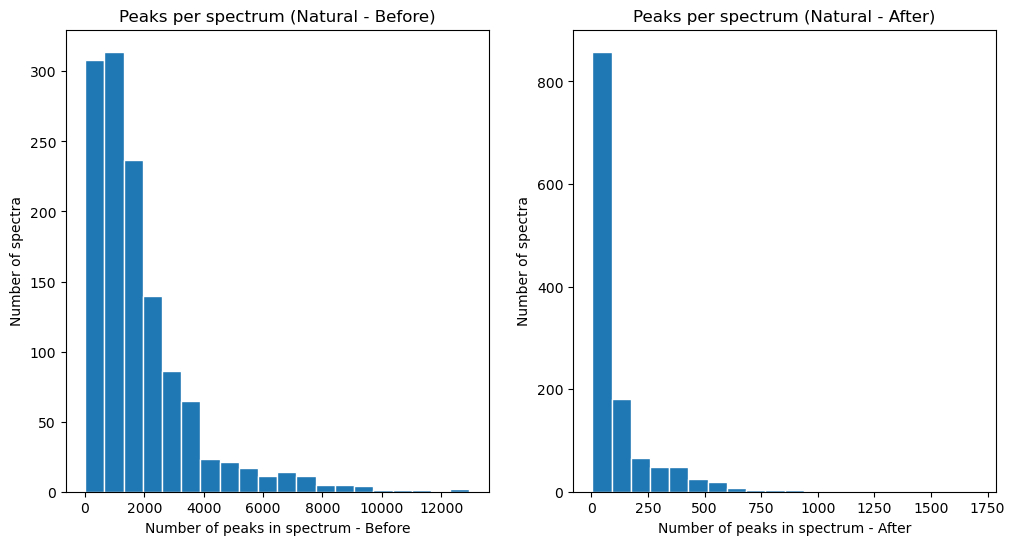

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi = 100)
ax[0].hist(numbers_of_peaks_natural, 20, edgecolor="white")
ax[0].set_title("Peaks per spectrum (Natural - Before)")
ax[1].hist(numbers_of_peaks_natural_processed, 20, edgecolor="white")
ax[1].set_title("Peaks per spectrum (Natural - After)")
ax[0].set_xlabel("Number of peaks in spectrum - Before")
ax[1].set_xlabel("Number of peaks in spectrum - After")
ax[0].set_ylabel("Number of spectra")
ax[1].set_ylabel("Number of spectra")
plt.show()

# Cosine Greedy & Modified Cosine

In [14]:
#Assignation of the Cosine measurements for each algorithm
similarity_measure_greedy = CosineGreedy(tolerance = 0.005)
similarity_measure_Mod = ModifiedCosine(tolerance = 0.005)

In [15]:
#A function to compare each fragment of sprectrum from the 1 list with all the fragments of spectra from the 2 list
def evaluate_matrix(s1, s2, similarity_measure):
    sim_score = []
    matched_peaks = []
    for sn in s2:
        sim_score_ = []
        matched_peaks_ = []
        for sph in s1:
            score1 = similarity_measure.pair(sph, sn)
            sim_score_.append(score1["score"])
            matched_peaks_.append(score1["matches"])
        sim_score.append(sim_score_)
        matched_peaks.append(matched_peaks_)

    sim_score = np.array(sim_score)
    matched_peaks = np.array(matched_peaks)
    return [sim_score, matched_peaks]

In [16]:
#Obtation of similarity scores and matched peaks with the measurement of Cosine Greedy
[score_greedy, peaks_greedy] = evaluate_matrix(spectrums_natural_processed[:1266], spectrums_pharma_processed[:1266], similarity_measure_greedy)

In [17]:
#Obtation of similarity scores and matched peaks with the measurement of Modified Cosine
[score_mod, peaks_mod] = evaluate_matrix(spectrums_natural_processed[:1266], spectrums_pharma_processed[:1266], similarity_measure_Mod)

In [18]:
print(score_greedy)
len(score_greedy)  #number of elements

[[0.00528417 0.00182963 0.00538961 ... 0.01983548 0.0047847  0.13518134]
 [0.05870616 0.00309624 0.00132685 ... 0.00279612 0.00018115 0.00362526]
 [0.         0.         0.         ... 0.00032946 0.         0.01360087]
 ...
 [0.0019818  0.01119325 0.00910039 ... 0.02005399 0.01216599 0.10799265]
 [0.         0.         0.         ... 0.         0.         0.00358323]
 [0.         0.05201532 0.00070477 ... 0.00895284 0.00487452 0.00866667]]


1266

In [19]:
print(peaks_greedy)

[[ 6  7  7 ... 14  5 57]
 [ 5  3  1 ...  2  1  5]
 [ 0  0  0 ...  1  0  5]
 ...
 [ 2  6 11 ... 13  5 33]
 [ 0  0  0 ...  0  0  1]
 [ 0  1  1 ...  4  1  6]]


In [20]:
print(score_mod)

[[0.00572454 0.00271872 0.04718747 ... 0.03532306 0.01563757 0.13535382]
 [0.05870616 0.00327693 0.00132685 ... 0.00279612 0.00018115 0.00362526]
 [0.         0.0004606  0.0001745  ... 0.00032946 0.         0.01360087]
 ...
 [0.00232398 0.01298374 0.01040331 ... 0.03894488 0.01224651 0.10839648]
 [0.         0.         0.         ... 0.         0.         0.00378612]
 [0.         0.05201532 0.13586493 ... 0.00895284 0.00928831 0.00866667]]


In [21]:
print(peaks_mod)

[[ 8 12 13 ... 16  9 59]
 [ 5  4  1 ...  2  1  5]
 [ 0  1  1 ...  1  0  5]
 ...
 [ 3 10 13 ... 16  6 35]
 [ 0  0  0 ...  0  0  2]
 [ 0  1  3 ...  4  2  6]]


# Spec2Vec

In [22]:
#path_model = os.path.join(os.path.dirname(os.getcwd()),"CEU")
path_model = ""
filename = os.path.join(path_model, "spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model")
model = gensim.models.Word2Vec.load(filename) #Importing the model
model.wv.index_to_key[0] #To see the intensity peak in position 0

'peak@105.07'

In [23]:
#Assignation of spec2vec measurements 
spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5, allowed_missing_percentage=5.0)

In [24]:
#Obtation of similarity scores with the implementation of spec2vec
scores = calculate_scores(spectrums_natural_processed[:1266], spectrums_pharma_processed[:1266], spec2vec_similarity)
#Transform the scores into an array for the comparison
scores_spec2vec = scores.scores.to_array()

In [1]:
print(scores_spec2vec)

NameError: name 'scores_spec2vec' is not defined

# Tanimoto

In [26]:
#Function declared for the obtation of fingerprints from the molecules structural "smiles"
def FromSmileToFgp(spectrums):
    smiles = []
    for spec in spectrums:
        smiles.append(spec.get("smiles"))

    molecules = []
    for smile in smiles:
        molecules.append(Chem.MolFromSmiles(smile))

    rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7)
    fgrps = [rdkit_gen.GetFingerprint(molecule) for molecule in molecules]
    return fgrps

In [27]:
#Obtation of the fingerprints for each spectral library
fgps_pharma = FromSmileToFgp(spectrums_pharma_processed)
fgps_natural = FromSmileToFgp(spectrums_natural_processed)

In [28]:
#Function declared for the comparison of each fingerprint previously obtained
def pairwise_similarity(fingerprints1, fingerprints2):
    nfgps1 = len(fingerprints1)
    nfgps2 = len(fingerprints2)
    similarities = np.zeros((nfgps1, nfgps2))
    
    for i in range(nfgps1):
            similarity = DataStructs.BulkTanimotoSimilarity(fingerprints1[i], fingerprints2[:i])
            similarities[i, :i] = similarity
            similarities[:i, i] = similarity
    return similarities

In [29]:
#Obtation of Tanimoto scores
scores_tanimoto = pairwise_similarity(fgps_pharma, fgps_natural)

In [30]:
print(scores_tanimoto)

[[0.         0.30268199 0.31821214 ... 0.26789838 0.25263158 0.28337062]
 [0.30268199 0.         0.35637286 ... 0.26044568 0.26837725 0.31015299]
 [0.31821214 0.35637286 0.         ... 0.19074074 0.20833333 0.20674357]
 ...
 [0.26789838 0.26044568 0.19074074 ... 0.         0.25560538 0.31240545]
 [0.25263158 0.26837725 0.20833333 ... 0.25560538 0.         0.27406199]
 [0.28337062 0.31015299 0.20674357 ... 0.31240545 0.27406199 0.        ]]


## Errors

In [31]:
#Function declared to the calculation of RMSE
def RMSE(X,Y):
    return np.sqrt((X-Y)**2)

In [32]:
#RMSE calculation for each algorithm used (score of the algorithm used- Tanimoto score)
RMSE_greedy = RMSE(score_greedy,scores_tanimoto)
RMSE_mod = RMSE(score_mod,scores_tanimoto)
RMSE_s2v = RMSE(scores_spec2vec,scores_tanimoto)

In [33]:
print(RMSE_greedy)


[[0.00528417 0.30085236 0.31282254 ... 0.2480629  0.24784688 0.14818928]
 [0.24397583 0.00309624 0.35504601 ... 0.25764956 0.2681961  0.30652773]
 [0.31821214 0.35637286 0.         ... 0.19041128 0.20833333 0.1931427 ]
 ...
 [0.26591658 0.24925243 0.18164035 ... 0.02005399 0.24343939 0.20441279]
 [0.25263158 0.26837725 0.20833333 ... 0.25560538 0.         0.27047876]
 [0.28337062 0.25813767 0.2060388  ... 0.3034526  0.26918747 0.00866667]]


In [34]:
print(RMSE_mod)


[[5.72453525e-03 2.99963271e-01 2.71024667e-01 ... 2.32575327e-01
  2.36994011e-01 1.48016799e-01]
 [2.43975830e-01 3.27692835e-03 3.55046007e-01 ... 2.57649559e-01
  2.68196100e-01 3.06527726e-01]
 [3.18212141e-01 3.55912263e-01 1.74504133e-04 ... 1.90411280e-01
  2.08333333e-01 1.93142699e-01]
 ...
 [2.65574403e-01 2.47461944e-01 1.80337432e-01 ... 3.89448814e-02
  2.43358869e-01 2.04008962e-01]
 [2.52631579e-01 2.68377254e-01 2.08333333e-01 ... 2.55605381e-01
  0.00000000e+00 2.70275873e-01]
 [2.83370619e-01 2.58137672e-01 7.08786396e-02 ... 3.03452604e-01
  2.64773676e-01 8.66666578e-03]]


In [35]:
print(RMSE_s2v)

[[0.05383204 0.16295288 0.30632031 ... 0.16781537 0.152806   0.32487161]
 [0.25508724 0.00608433 0.32616983 ... 0.13876471 0.09190718 0.21511775]
 [0.23350212 0.24561461 0.10106716 ... 0.08823496 0.12891634 0.19442247]
 ...
 [0.21979485 0.19333904 0.05201538 ... 0.05996385 0.1896902  0.30070589]
 [0.22051169 0.17286466 0.1611839  ... 0.21603325 0.05582205 0.21591411]
 [0.08302864 0.18632388 0.03188103 ... 0.04088866 0.1879725  0.07787749]]


In [36]:
#Function to create the histogram divided in bins with a step size of 0.1
def calculate_histogram(RMSE):
    h = []
    bins = np.arange(0,1.1,0.1)
    RMSE = RMSE.flatten()

    for k in range(0,len(bins)-1):
        aux = np.argwhere(RMSE>=bins[k])       
        aux = np.argwhere(RMSE[aux]<=bins[k+1])
        h.append(len(aux))

    return h

In [37]:
#Implementation of the function for each RMSE value
h_greedy = calculate_histogram(RMSE_greedy)
h_mod = calculate_histogram(RMSE_mod)
h_s2v = calculate_histogram(RMSE_s2v)

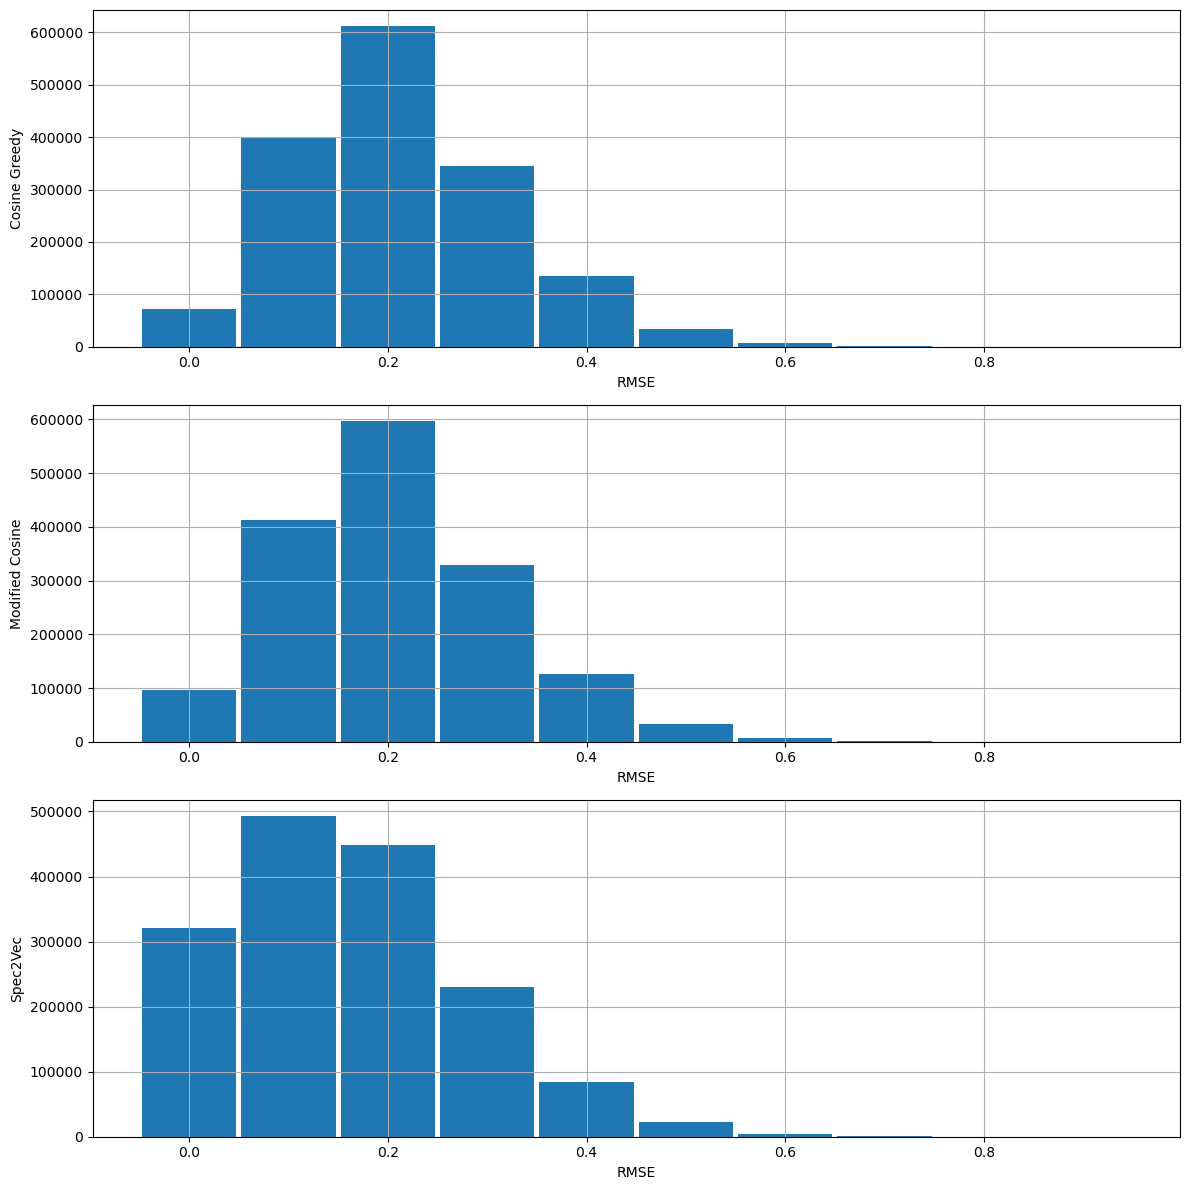

In [38]:
#To see the plot with both axes and all the information
bins = [x/10 for x in range(0,10)]
fig, ax = plt.subplots(3, 1, figsize=(12,12), dpi = 100)
ax[0].bar(bins, h_greedy, width=0.095)
ax[0].set_ylabel("Cosine Greedy")
ax[0].set_xlabel("RMSE")
ax[0].grid()
ax[1].bar(bins, h_mod, width=0.095)
ax[1].set_ylabel("Modified Cosine")
ax[1].set_xlabel("RMSE")
ax[1].grid()
ax[2].bar(bins, h_s2v, width=0.095)
ax[2].set_ylabel("Spec2Vec")
ax[2].set_xlabel("RMSE")
ax[2].grid()
plt.tight_layout()
plt.show()

# Other spectral libraries: CLINICAL COLLECTION1

In [39]:
collection1_file_mgf= "GNPS-NIH-CLINICALCOLLECTION1.mgf"
spectrumsCollection1 = list(load_from_mgf(collection1_file_mgf))

In [40]:
print(len(spectrumsCollection1))
spectrumsCollection1 = spectrumsCollection1[:377]
spectrumsNatural = spectrumsNatural[:377]

377


In [41]:
numbers_of_peaks_Collection1 = [len(s.peaks.mz) for s in spectrumsCollection1]
numbers_of_peaks_Natural = [len(s.peaks.mz) for s in  spectrumsNatural]
spectrums_Collection1_processed = [metadata_processing(s) for s in spectrumsCollection1]
spectrums_Collection1_processed = [peak_processing(s) for s in spectrums_Collection1_processed]
spectrums_Natural_processed = [metadata_processing(s) for s in spectrumsNatural]
spectrums_Natural_processed = [peak_processing(s) for s in spectrums_Natural_processed]
numbers_of_peaks_Collection1_processed = [len(s.peaks.mz) for s in spectrums_Collection1_processed]
numbers_of_peaks_Natural_processed = [len(s.peaks.mz) for s in spectrums_Natural_processed]

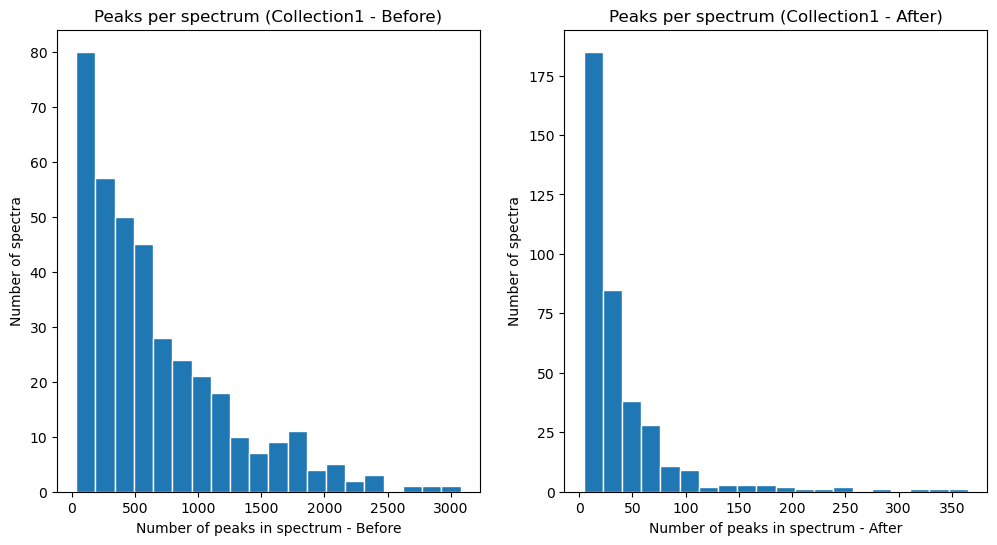

In [42]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi = 100)
ax[0].hist(numbers_of_peaks_Collection1, 20, edgecolor="white")
ax[0].set_title("Peaks per spectrum (Collection1 - Before)")
ax[1].hist(numbers_of_peaks_Collection1_processed , 20, edgecolor="white")
ax[1].set_title("Peaks per spectrum (Collection1 - After)")
ax[0].set_xlabel("Number of peaks in spectrum - Before")
ax[1].set_xlabel("Number of peaks in spectrum - After")
ax[0].set_ylabel("Number of spectra")
ax[1].set_ylabel("Number of spectra")
plt.show()

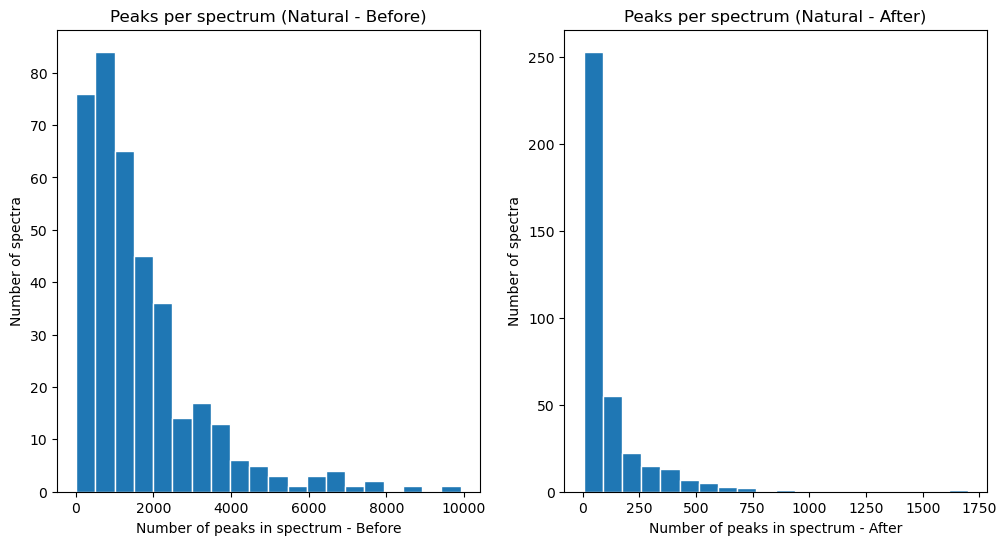

In [43]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi = 100)
ax[0].hist(numbers_of_peaks_Natural, 20, edgecolor="white")
ax[0].set_title("Peaks per spectrum (Natural - Before)")
ax[1].hist(numbers_of_peaks_Natural_processed , 20, edgecolor="white")
ax[1].set_title("Peaks per spectrum (Natural - After)")
ax[0].set_xlabel("Number of peaks in spectrum - Before")
ax[1].set_xlabel("Number of peaks in spectrum - After")
ax[0].set_ylabel("Number of spectra")
ax[1].set_ylabel("Number of spectra")
plt.show()

In [44]:
[score_greedy1, peaks_greedy1] = evaluate_matrix(spectrums_Collection1_processed[:377], spectrums_Natural_processed[:377], similarity_measure_greedy)

In [45]:
[score_mod1, peaks_mod1] = evaluate_matrix(spectrums_Collection1_processed[:377], spectrums_Natural_processed[:377], similarity_measure_Mod)

In [46]:
print(score_greedy1)
len(score_greedy1) 

[[1.00952471e-01 1.14302415e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.80886945e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.07916886e-03 4.55411004e-03 8.53458142e-05 ... 1.36340668e-03
  7.30762134e-04 0.00000000e+00]
 [4.54681363e-03 0.00000000e+00 0.00000000e+00 ... 9.86922571e-03
  4.45783121e-03 0.00000000e+00]
 [2.04331768e-02 3.04182756e-04 0.00000000e+00 ... 3.49600205e-04
  0.00000000e+00 0.00000000e+00]]


377

In [47]:
print(peaks_greedy1)

[[4 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [3 9 1 ... 6 4 0]
 [2 0 0 ... 4 3 0]
 [2 2 0 ... 2 0 0]]


In [48]:
print(score_mod1)

[[0.10095247 0.01376212 0.         ... 0.         0.         0.        ]
 [0.         0.00205889 0.         ... 0.         0.         0.00071583]
 [0.17651085 0.18375766 0.36633546 ... 0.27525954 0.56047052 0.52876062]
 ...
 [0.00557424 0.00728032 0.00531102 ... 0.00513858 0.0085676  0.00727276]
 [0.06242264 0.00279099 0.00549616 ... 0.01383981 0.01270032 0.00764921]
 [0.03476276 0.01886265 0.03039944 ... 0.0211144  0.04692059 0.04036135]]


In [49]:
print(peaks_mod1)

[[ 4  3  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  2]
 [ 5  3  3 ...  4  4  5]
 ...
 [ 4 11  2 ...  7  5  1]
 [ 5  1  1 ...  5  4  1]
 [ 5  8  2 ...  3  3  3]]


In [50]:
scores1 = calculate_scores(spectrums_Collection1_processed[:377], spectrums_Natural_processed[:377], spec2vec_similarity)
scores_spec2vec1 = scores1.scores.to_array()
print(scores_spec2vec1)

[[ 0.2726379   0.06036078  0.08770726 ... -0.00821261  0.03345366
   0.18562607]
 [ 0.27321144  0.10646272  0.05004851 ...  0.1684732   0.012744
   0.06045572]
 [ 0.05090259  0.05795927 -0.07229326 ...  0.14245922  0.04332293
  -0.03485969]
 ...
 [-0.04708012 -0.00500153 -0.02982873 ...  0.01399872 -0.0990905
   0.03335447]
 [-0.03536875  0.04685628 -0.01779327 ...  0.01955434 -0.10682193
  -0.01147551]
 [-0.02069528  0.04970343 -0.10911819 ...  0.08287621 -0.01863777
  -0.03214202]]


In [51]:
fgps_Collection1 = FromSmileToFgp(spectrums_Collection1_processed)
fgps_Natural = FromSmileToFgp(spectrums_Natural_processed)

In [52]:
scores_tanimoto1 = pairwise_similarity(fgps_Collection1, fgps_Natural)
print(scores_tanimoto1)

[[0.         0.4452765  0.48552703 ... 0.4624183  0.48179872 0.48179872]
 [0.4452765  0.         0.53678038 ... 0.53448276 0.55573248 0.55573248]
 [0.48552703 0.53678038 0.         ... 0.33180516 0.33204206 0.33204206]
 ...
 [0.4624183  0.53448276 0.33180516 ... 0.         0.55315704 0.55315704]
 [0.48179872 0.55573248 0.33204206 ... 0.55315704 0.         0.39830986]
 [0.48179872 0.55573248 0.33204206 ... 0.55315704 0.39830986 0.        ]]


In [53]:
RMSE_greedy1 = RMSE(score_greedy1,scores_tanimoto1)
RMSE_mod1 = RMSE(score_mod1,scores_tanimoto1)
RMSE_s2v1 = RMSE(scores_spec2vec1,scores_tanimoto1)

In [54]:
print(RMSE_greedy1)

[[0.10095247 0.43384626 0.48552703 ... 0.4624183  0.48179872 0.48179872]
 [0.4452765  0.         0.53678038 ... 0.53448276 0.55573248 0.55573248]
 [0.47971816 0.53678038 0.         ... 0.33180516 0.33204206 0.33204206]
 ...
 [0.45933913 0.52992865 0.33171981 ... 0.00136341 0.55242628 0.55315704]
 [0.4772519  0.55573248 0.33204206 ... 0.54328782 0.00445783 0.39830986]
 [0.46136554 0.5554283  0.33204206 ... 0.55280744 0.39830986 0.        ]]


In [55]:
print(RMSE_mod1)

[[0.10095247 0.43151438 0.48552703 ... 0.4624183  0.48179872 0.48179872]
 [0.4452765  0.00205889 0.53678038 ... 0.53448276 0.55573248 0.55501665]
 [0.30901619 0.35302272 0.36633546 ... 0.05654562 0.22842846 0.19671856]
 ...
 [0.45684406 0.52720243 0.32649414 ... 0.00513858 0.54458944 0.54588428]
 [0.41937607 0.55294149 0.3265459  ... 0.53931723 0.01270032 0.39066065]
 [0.44703595 0.53686983 0.30164262 ... 0.53204264 0.35138927 0.04036135]]


In [56]:
print(RMSE_s2v1)

[[0.2726379  0.38491571 0.39781977 ... 0.47063091 0.44834506 0.29617265]
 [0.17206506 0.10646272 0.48673187 ... 0.36600956 0.54298848 0.49527676]
 [0.43462444 0.47882112 0.07229326 ... 0.18934594 0.28871913 0.36690175]
 ...
 [0.50949842 0.53948429 0.36163389 ... 0.01399872 0.65224754 0.51980257]
 [0.51716747 0.5088762  0.34983532 ... 0.5336027  0.10682193 0.40978537]
 [0.50249399 0.50602905 0.44116024 ... 0.47028083 0.41694763 0.03214202]]


In [57]:
h_greedy1 = calculate_histogram(RMSE_greedy1)
h_mod1 = calculate_histogram(RMSE_mod1)
h_s2v1 = calculate_histogram(RMSE_s2v1)

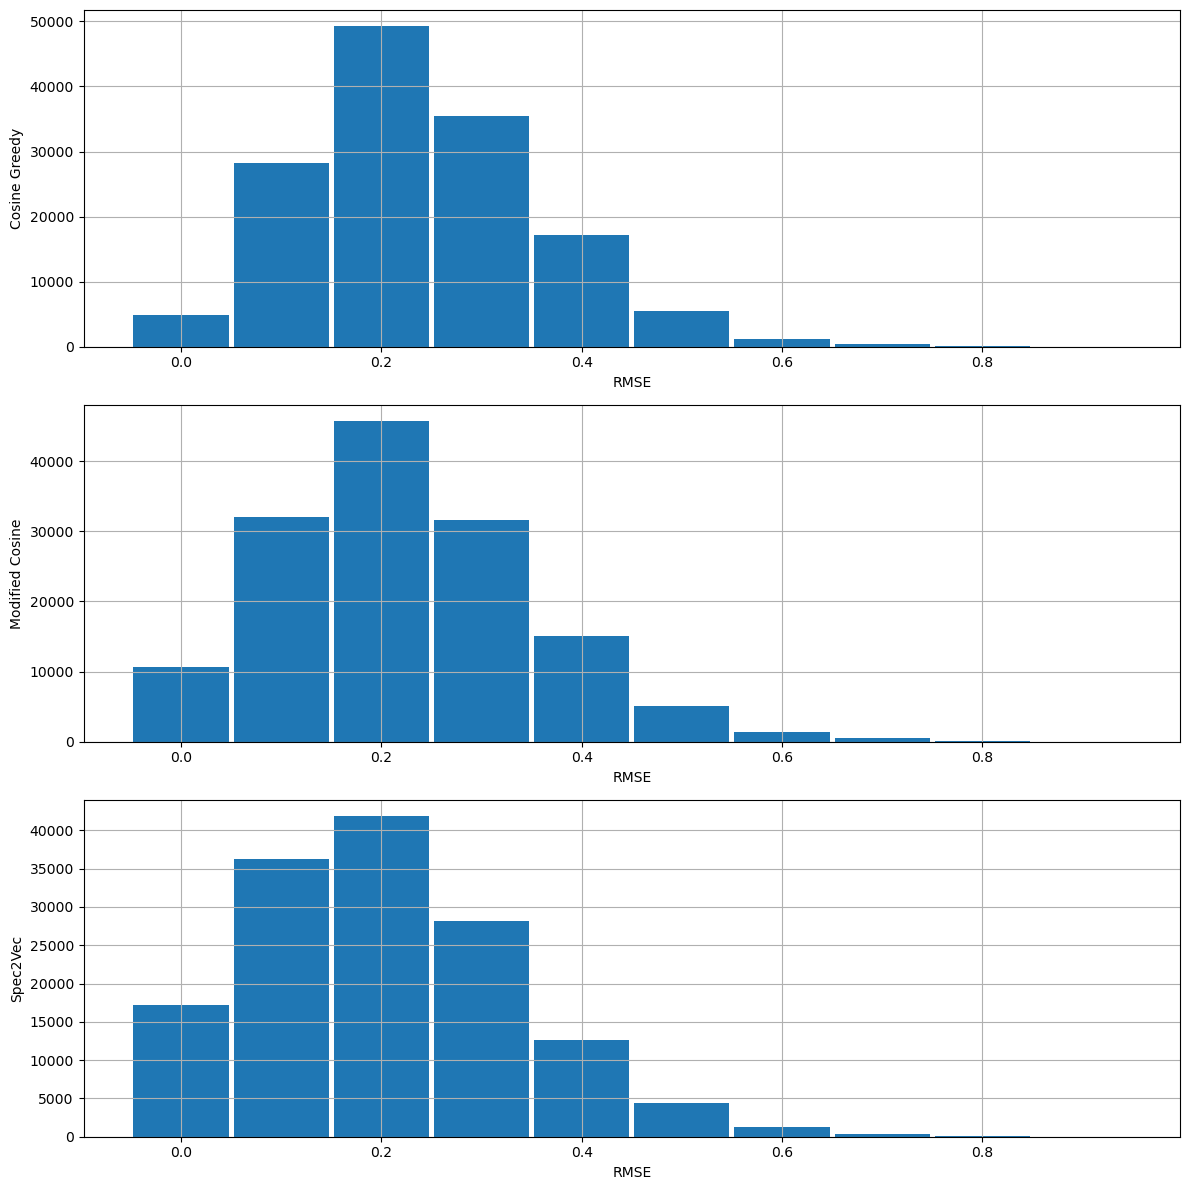

In [58]:
bins = [x/10 for x in range(0,10)]
fig, ax = plt.subplots(3, 1, figsize=(12,12), dpi = 100)
ax[0].bar(bins, h_greedy1, width=0.095)
ax[0].set_ylabel("Cosine Greedy")
ax[0].set_xlabel("RMSE")
ax[0].grid()
ax[1].bar(bins, h_mod1, width=0.095)
ax[1].set_ylabel("Modified Cosine")
ax[1].set_xlabel("RMSE")
ax[1].grid()
ax[2].bar(bins, h_s2v1, width=0.095)
ax[2].set_ylabel("Spec2Vec")
ax[2].set_xlabel("RMSE")
ax[2].grid()
plt.tight_layout()
plt.show()

# Other spectral libraries: CLINICAL COLLECTION1

In [59]:
drugs_file_mgf= "DRUGS-OF-ABUSE-LIBRARY.mgf"
spectrumsDrugs = list(load_from_mgf(drugs_file_mgf))

In [60]:
print(len(spectrumsDrugs))
spectrumsDrugs = spectrumsDrugs[:479]
spectrumsPharma = spectrumsPharma[:479]

480


In [61]:
numbers_of_peaks_Drugs = [len(s.peaks.mz) for s in spectrumsDrugs]
numbers_of_peaks_Pharma = [len(s.peaks.mz) for s in spectrumsPharma]
spectrums_Drugs_processed = [metadata_processing(s) for s in spectrumsDrugs]
spectrums_Drugs_processed = [peak_processing(s) for s in spectrums_Drugs_processed]
spectrums_Pharma_processed = [metadata_processing(s) for s in spectrumsPharma]
spectrums_Pharma_processed = [peak_processing(s) for s in spectrums_Pharma_processed]
numbers_of_peaks_Drugs_processed = [len(s.peaks.mz) for s in spectrums_Drugs_processed]
numbers_of_peaks_Pharma_processed = [len(s.peaks.mz) for s in spectrums_Pharma_processed]

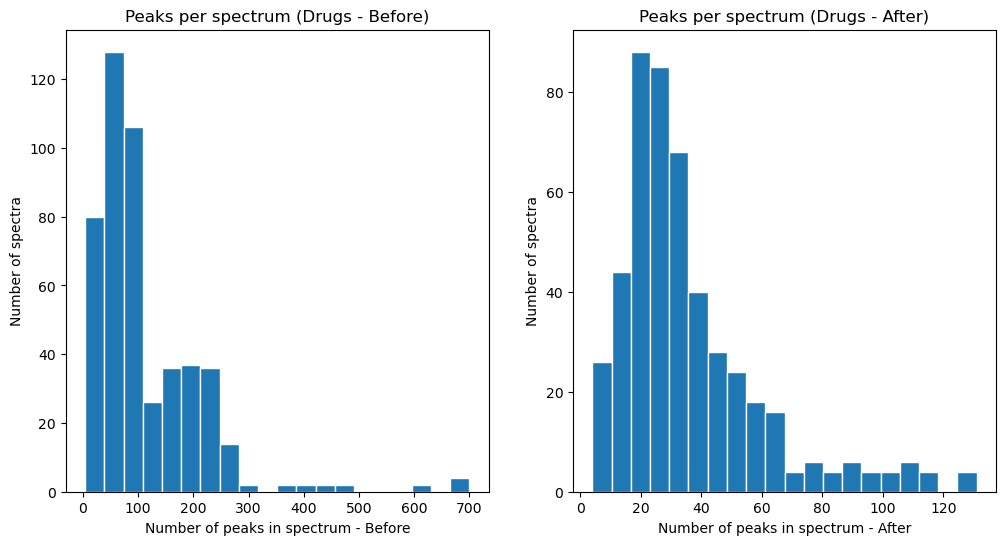

In [62]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi = 100)
ax[0].hist(numbers_of_peaks_Drugs, 20, edgecolor="white")
ax[0].set_title("Peaks per spectrum (Drugs - Before)")
ax[1].hist(numbers_of_peaks_Drugs_processed , 20, edgecolor="white")
ax[1].set_title("Peaks per spectrum (Drugs - After)")
ax[0].set_xlabel("Number of peaks in spectrum - Before")
ax[1].set_xlabel("Number of peaks in spectrum - After")
ax[0].set_ylabel("Number of spectra")
ax[1].set_ylabel("Number of spectra")
plt.show()

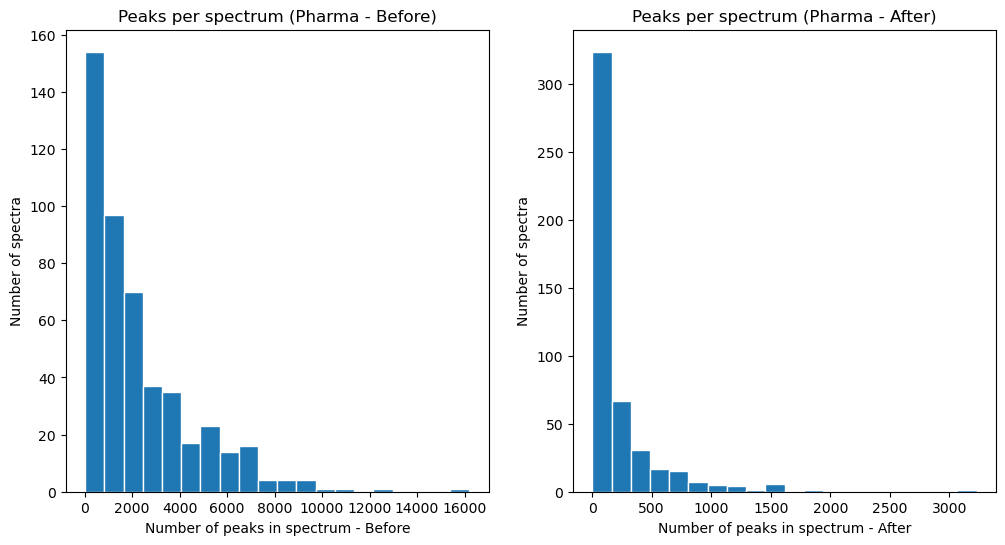

In [63]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi = 100)
ax[0].hist(numbers_of_peaks_Pharma, 20, edgecolor="white")
ax[0].set_title("Peaks per spectrum (Pharma - Before)")
ax[1].hist(numbers_of_peaks_Pharma_processed , 20, edgecolor="white")
ax[1].set_title("Peaks per spectrum (Pharma - After)")
ax[0].set_xlabel("Number of peaks in spectrum - Before")
ax[1].set_xlabel("Number of peaks in spectrum - After")
ax[0].set_ylabel("Number of spectra")
ax[1].set_ylabel("Number of spectra")
plt.show()

In [64]:
[score_greedy2, peaks_greedy2] = evaluate_matrix(spectrums_Drugs_processed[:479], spectrums_Pharma_processed[:479], similarity_measure_greedy)

In [65]:
[score_mod2, peaks_mod2] = evaluate_matrix(spectrums_Drugs_processed[:479], spectrums_Pharma_processed[:479], similarity_measure_Mod)

In [66]:
print(score_greedy2)
len(score_greedy2) 

[[0.00000000e+00 6.02239153e-03 7.06834359e-03 ... 2.84486553e-03
  1.11294048e-04 8.69891013e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.31242171e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 1.75786192e-03 2.04358556e-03 ... 1.67666349e-03
  2.98185145e-04 2.03728189e-01]
 [0.00000000e+00 1.57358756e-03 2.27856401e-03 ... 3.70120525e-04
  0.00000000e+00 2.10808815e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 4.59376809e-03]]


479

In [67]:
print(peaks_greedy2)

[[ 0  3  5 ...  3  1 26]
 [ 0  0  0 ...  0  0  5]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  4  5 ...  2  1 24]
 [ 0  1  2 ...  1  0  3]
 [ 0  0  0 ...  0  0  6]]


In [68]:
print(score_mod2)

[[0.         0.00602239 0.00743231 ... 0.04266214 0.04870951 0.10787923]
 [0.00127842 0.         0.         ... 0.         0.01063411 0.01312422]
 [0.         0.         0.         ... 0.00627985 0.01521182 0.        ]
 ...
 [0.         0.00175786 0.00204359 ... 0.00974639 0.0087153  0.21607969]
 [0.         0.00157359 0.00227856 ... 0.06272367 0.07653723 0.0450989 ]
 [0.         0.         0.         ... 0.12754219 0.15468309 0.09198459]]


In [69]:
print(peaks_greedy2)

[[ 0  3  5 ...  3  1 26]
 [ 0  0  0 ...  0  0  5]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  4  5 ...  2  1 24]
 [ 0  1  2 ...  1  0  3]
 [ 0  0  0 ...  0  0  6]]


In [70]:
print(peaks_mod2)

[[ 0  3  7 ...  4  4 35]
 [ 1  0  0 ...  0  1  5]
 [ 0  0  0 ...  1  1  0]
 ...
 [ 0  4  5 ...  7  2 28]
 [ 0  1  2 ...  2  2  5]
 [ 0  0  0 ...  1  1  7]]


In [71]:
scores2 = calculate_scores(spectrums_Drugs_processed[:479], spectrums_Pharma_processed[:479], spec2vec_similarity)
scores_spec2vec2 = scores2.scores.to_array()
print(scores_spec2vec2)

[[ 0.03910272  0.04691993 -0.01402579 ...  0.14092252 -0.07175484
   0.05981355]
 [ 0.04133378 -0.08527441  0.09195597 ...  0.05051685  0.07145528
   0.04214467]
 [ 0.02548036 -0.05301845  0.06096387 ...  0.06254013  0.04818719
   0.02078558]
 ...
 [ 0.05838236 -0.01447662  0.12723795 ...  0.05227224 -0.00474509
  -0.04370432]
 [ 0.01101085  0.06947493 -0.01788444 ... -0.01998337  0.05460868
   0.07043786]
 [ 0.05276722  0.08798955  0.01106629 ...  0.20709952  0.00986631
   0.11478955]]


In [72]:
fgps_Drugs = FromSmileToFgp(spectrums_Drugs_processed)
fgps_Pharma = FromSmileToFgp(spectrums_Pharma_processed)

In [73]:
scores_tanimoto2 = pairwise_similarity(fgps_Drugs, fgps_Pharma)
print(scores_tanimoto2)

[[0.         0.22691552 0.22822823 ... 0.15714286 0.17255217 0.19401198]
 [0.22691552 0.         0.22990493 ... 0.23407775 0.25435276 0.2185904 ]
 [0.22822823 0.22990493 0.         ... 0.32137519 0.31765508 0.2160596 ]
 ...
 [0.15714286 0.23407775 0.32137519 ... 0.         0.24186391 0.21865597]
 [0.17255217 0.25435276 0.31765508 ... 0.24186391 0.         0.1517067 ]
 [0.19401198 0.2185904  0.2160596  ... 0.21865597 0.1517067  0.        ]]


In [74]:
RMSE_greedy2 = RMSE(score_greedy2,scores_tanimoto2)
RMSE_mod2 = RMSE(score_mod2,scores_tanimoto2)
RMSE_s2v2 = RMSE(scores_spec2vec2,scores_tanimoto2)

In [75]:
print(RMSE_greedy2)

[[0.         0.22089313 0.22115988 ... 0.15429799 0.17244087 0.10702287]
 [0.22691552 0.         0.22990493 ... 0.23407775 0.25435276 0.20546618]
 [0.22822823 0.22990493 0.         ... 0.32137519 0.31765508 0.2160596 ]
 ...
 [0.15714286 0.23231989 0.3193316  ... 0.00167666 0.24156572 0.01492778]
 [0.17255217 0.25277918 0.31537651 ... 0.24149378 0.         0.14959861]
 [0.19401198 0.2185904  0.2160596  ... 0.21865597 0.1517067  0.00459377]]


In [76]:
print(RMSE_mod2)

[[0.         0.22089313 0.22079592 ... 0.11448072 0.12384266 0.08613274]
 [0.22563711 0.         0.22990493 ... 0.23407775 0.24371865 0.20546618]
 [0.22822823 0.22990493 0.         ... 0.31509534 0.30244325 0.2160596 ]
 ...
 [0.15714286 0.23231989 0.3193316  ... 0.00974639 0.2331486  0.00257628]
 [0.17255217 0.25277918 0.31537651 ... 0.17914024 0.07653723 0.1066078 ]
 [0.19401198 0.2185904  0.2160596  ... 0.09111378 0.00297639 0.09198459]]


In [77]:
print(RMSE_s2v2)

[[0.03910272 0.1799956  0.24225402 ... 0.01622034 0.244307   0.13419842]
 [0.18558174 0.08527441 0.13794896 ... 0.1835609  0.18289749 0.17644573]
 [0.20274787 0.28292337 0.06096387 ... 0.25883506 0.26946789 0.19527403]
 ...
 [0.0987605  0.24855437 0.19413724 ... 0.05227224 0.246609   0.26236029]
 [0.16154132 0.18487784 0.33553952 ... 0.26184728 0.05460868 0.08126884]
 [0.14124475 0.13060085 0.20499332 ... 0.01155645 0.14184039 0.11478955]]


In [78]:
h_greedy2 = calculate_histogram(RMSE_greedy2)
h_mod2 = calculate_histogram(RMSE_mod2)
h_s2v2 = calculate_histogram(RMSE_s2v2)

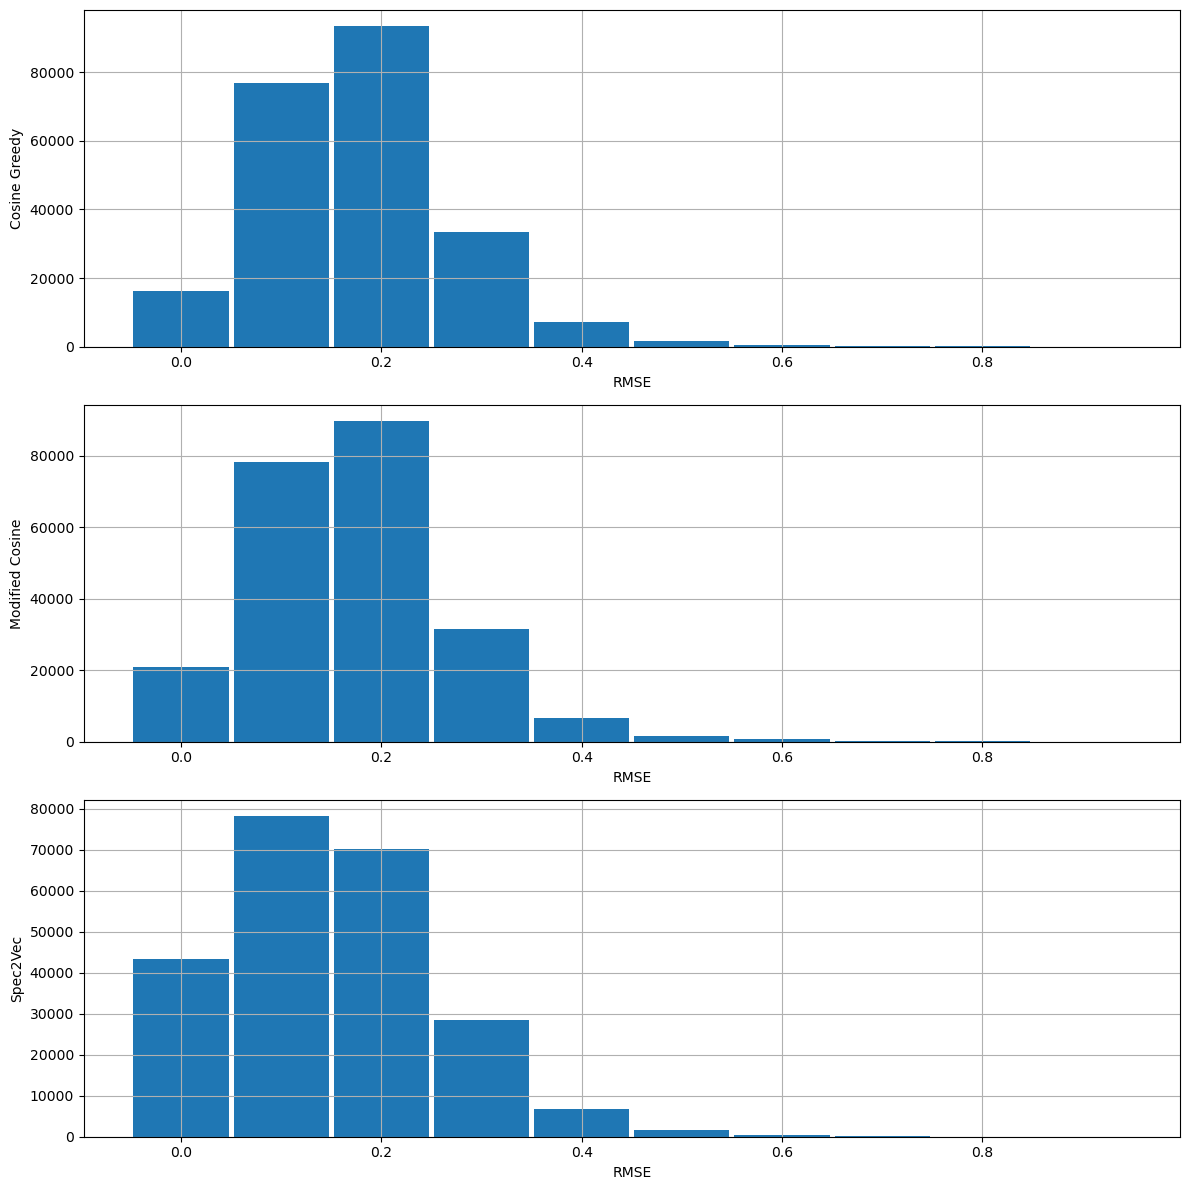

In [79]:
bins = [x/10 for x in range(0,10)]
fig, ax = plt.subplots(3, 1, figsize=(12,12), dpi = 100)
ax[0].bar(bins, h_greedy2, width=0.095)
ax[0].set_ylabel("Cosine Greedy")
ax[0].set_xlabel("RMSE")
ax[0].grid()
ax[1].bar(bins, h_mod2, width=0.095)
ax[1].set_ylabel("Modified Cosine")
ax[1].set_xlabel("RMSE")
ax[1].grid()
ax[2].bar(bins, h_s2v2, width=0.095)
ax[2].set_ylabel("Spec2Vec")
ax[2].set_xlabel("RMSE")
ax[2].grid()
plt.tight_layout()
plt.show()